In [1]:
# import packages
from utils import *

In [2]:
# read csv file of example Case-A
df = pd.read_csv('dataset_caseA.csv')

# select input and output columns
input_cols = ['TIME', 'ICV1', 'ICV2', 'ICV3']
output_cols = ['FWPT', 'SLFT1', 'SLFT2','SLFT3']

# construct inputs (X) and outputs (y)
X = df[input_cols].values
y = df[output_cols].values

In [3]:
# specify simulation parameters
total_sims=1330; sim_steps=502; xmin=0; xmax=10
discrete_count = xmax+1
output_size = len(output_cols); input_size = len(input_cols)-1; 
init_points = [[1,1,0], [0,1,1], [1,0,1], [1,1,1]]
noise_type = 'Uniform'
noise_level = 0.3
color_list = ['m', 'orange', 'green', 'red']
label_list = ['Random', 'LHS', 'Adaptive (8 Corners)', 'Adaptive (4 Corners)']

# prepare misc objects
counter = -1
icvconfs = {}
allsamples = []
for i in range(discrete_count): 
    for j in range(discrete_count): 
        for k in range(discrete_count): 
            icvconfs[(i,j,k)] = counter
            allsamples.append([i,j,k])
            counter +=1
allsamples.remove([0,0,0])

def groundtruth(point, icvconfs, sim_steps): 
    return y[(icvconfs[point]+1)*sim_steps-1]

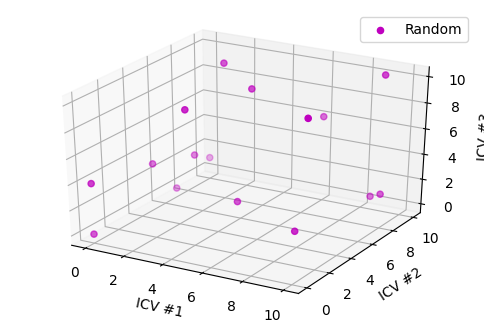

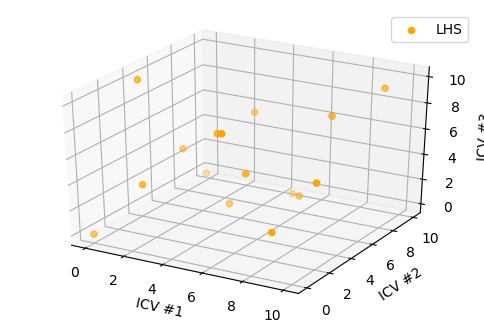

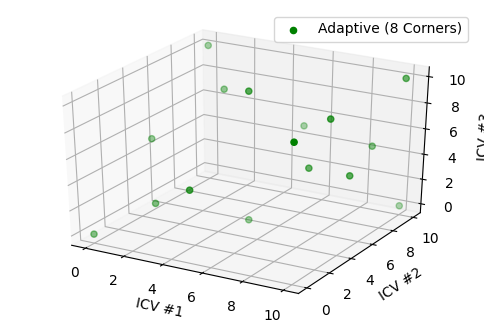

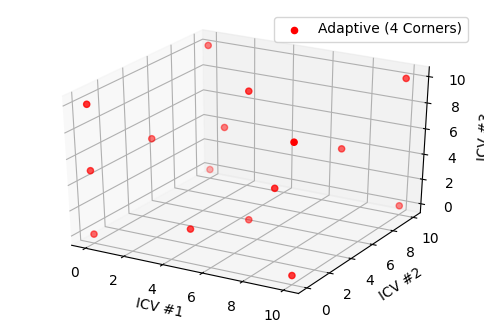

Uniform Noise is Added ...


In [12]:
# choose the total number of ICV field tests (N) to be performed
trainval_size = 15

# sample using random, LHS, four-corner adaptive, and 8-corner adaptive sampling
sample_random = random_sampler(trainval_size, total_sims, allsamples)
sample_lhs = lhs_sampler(trainval_size, xmin, xmax, dim=input_size)
sample_adaptive, losses, grads = adaptive_sampler(trainval_size, xmin, xmax, sim_steps, allsamples, icvconfs, groundtruth, output_size=output_size, input_size=input_size)
sample_hybrid, losses, grads = hybrid_sampler(trainval_size, xmin, xmax, sim_steps, allsamples, icvconfs, groundtruth, output_size=output_size, input_size=input_size, init_points=init_points)
plot_samples([sample_random, sample_lhs, sample_hybrid, sample_adaptive], color_list, label_list)
sample = sample_hybrid

# split trainval and test data
X_trainval, X_test, scaler_X, y_trainval, y_test, scaler_y = split(X, y, sample, trainval_size, icvconfs, total_sims, sim_steps, noise_level=noise_level, noise_type = noise_type)

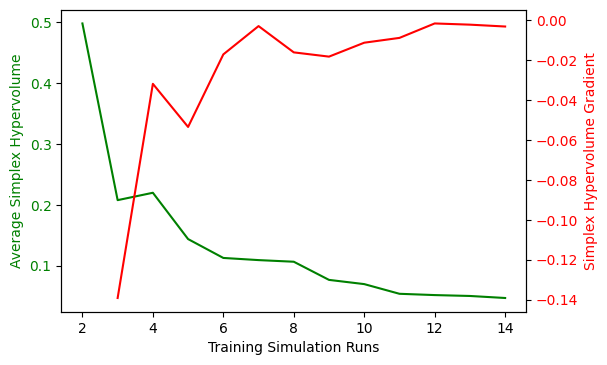

In [13]:
# plot simplix average hypervolumes 
plot_losses(losses, grads, filename='losses.png')

Text(0.5, 1.0, '30% Uniform Noise')

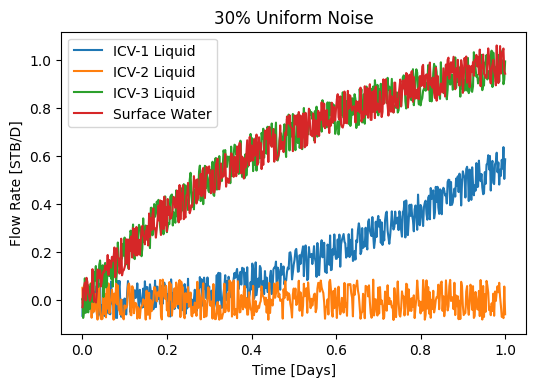

In [16]:
# visualizes example profiles
ts = 5
plt.plot(X_trainval[ts*sim_steps:(ts+1)*sim_steps,0], y_trainval[ts*sim_steps:(ts+1)*sim_steps])
plt.xlabel('Time [Days]')
plt.ylabel('Flow Rate [STB/D]')
plt.legend(['ICV-1 Liquid', 'ICV-2 Liquid', 'ICV-3 Liquid', 'Surface Water'])
plt.title(f'{noise_level*100:.0f}% {noise_type} Noise')

In [17]:
# train a cross-validated feedforward neural network 
mlp, score, y_pred = train_test_mlp(X_trainval, y_trainval, X_test, y_test)
score

0.8873562743308758

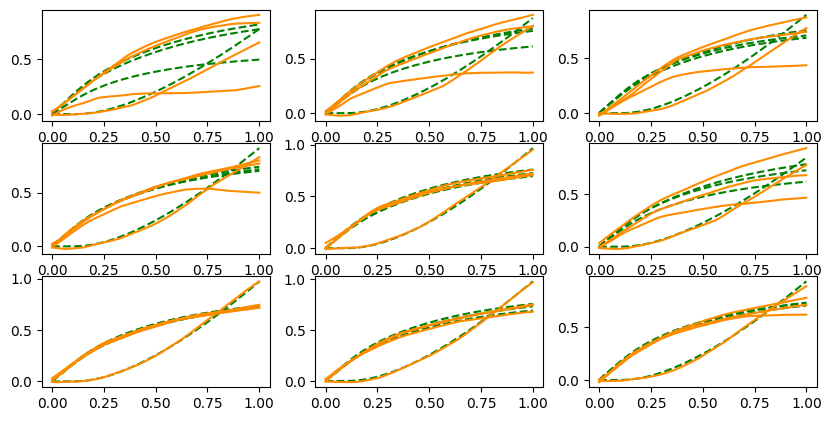

In [18]:
# visualize sample test and prediction results
plot_output(X_test, y_test, y_pred, scaler_X, scaler_y, total_sims, sim_steps, sample)